<a href="https://colab.research.google.com/github/Cyberbullying-Detection/Cyberbullying-Detection-on-Social-Media-using-Deep-Learning-and-Conventional-Machine-learning/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ktrain

In [ ]:
!pip install bert-for-tf2 >> /dev/null
!pip install sentencepiece >> /dev/null
!pip install keras-self-attention
!pip install tf
!pip install grpcio



!pip install --upgrade grpcio >> /dev/null
!pip install tqdm  >> /dev/null

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import ktrain
from ktrain import text
import tensorflow as tf

import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
print(tf.__version__)


2.5.0


In [ ]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/Cleaned_tweets_16k.csv")
data.drop(["contains_url","naughty_count","norm"], axis =1)

#columns_titles = ["tweet","label_bullying"]
columns_titles = ["text_message","label_bullying"]
data = data.reindex(columns=columns_titles)

In [ ]:

#columns_titles = ["tweet","label_bullying"]
columns_titles = ["text_message","label_bullying"]
data=data.reindex(columns=columns_titles)

In [ ]:
data.tail()

,text_message,label_bullying
15761,i want equal rights but i still want your seat...,1
15762,go ahead and call me sexist but scandalous wom...,1
15763,ive had the epic but i always kept it plugged...,0
15764,so do you think that the daesh are planning t...,0
15765,my skin green no colors suit only wear ripped...,0


In [ ]:
print("Size of dataset: ", data.shape)
#print("Size of test dataset: ", data_test.shape)

Size of dataset:  (15766, 2)


In [ ]:
data.head()

,text_message,label_bullying
0,another bloody instant restaurant week serious...,0
1,this video of the peshmerga decimating isis i...,0
2,oh really no more instant restaurants thats sh...,0
3,it hasnt been a good few weeks for isis a new ...,0
4,i don’t need femisnsn because men carry heavy ...,0


In [ ]:
data.count()

text_message      15764
label_bullying    15766
dtype: int64

In [ ]:
def shuffle_data(X, y):
    combined = list(zip(X, y))
    random.shuffle(combined)
    X[:], y[:] = zip(*combined)
    return X, y

In [ ]:
def repeat_positives(old_x, old_y, repeats=2):
    new_x = []
    new_y = []

    # rebuild the X dataset
    for i in range(len(old_x)):
        new_x.append(old_x[i])
        new_y.append(old_y[i])

        # if the example is a positive examples, repeat it in the dataset
        if old_y[i] == 1:
            for j in range(repeats-1):
                new_x.append(old_x[i])
                new_y.append(old_y[i])

    return new_x, new_y

In [ ]:
X = data[:]['text_message']
X

0        another bloody instant restaurant week serious...
1         this video of the peshmerga decimating isis i...
2        oh really no more instant restaurants thats sh...
3        it hasnt been a good few weeks for isis a new ...
4        i don’t need femisnsn because men carry heavy ...
                               ...                        
15761    i want equal rights but i still want your seat...
15762    go ahead and call me sexist but scandalous wom...
15763     ive had the epic but i always kept it plugged...
15764     so do you think that the daesh are planning t...
15765     my skin green no colors suit only wear ripped...
Name: text_message, Length: 15766, dtype: object

In [ ]:
Y = data[:]['label_bullying']
Y

0        0
1        0
2        0
3        0
4        0
        ..
15761    1
15762    1
15763    0
15764    0
15765    0
Name: label_bullying, Length: 15766, dtype: int64

In [ ]:
import random
shuffle_data(X,Y)
X,Y = repeat_positives(X,Y)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)


In [ ]:
len(X)

1477

In [ ]:
x_train = X[:1034]
x_test = X[1034:]
y_train = Y[:1034]
y_test = Y[1034:]

In [ ]:
# the train and test percentages of the usual MLs have to be the same as here

# x_train = data[:700]["text_message"]
# x_test = data[700:]["text_message"]
# y_train = data[:700]["label_bullying"]
# y_test = data[700:]["label_bullying"]

#x_train = data[:12000]["tweet"]
#x_test = data[12000:]["tweet"]
#y_train = data[:12000]["label_bullying"]
#y_test = data[12000:]["label_bullying"]

In [ ]:
train = pd.DataFrame(
    {'text': x_train,
     'label': y_train
    })

test = pd.DataFrame(
    {'text': x_test,
     'label': y_test
    })

In [ ]:
x_train[0:5]

['okay before anything yes i am gay  boujie and a fag lol call it what you want  but this happen when i first came',
 'females get out of a relationship and all of a sudden start posting excerpts from books and shit lmaoooooooooo ohhhh so n',
 'my mum finds me irritating and tells me to shut up every time i open my damn mouth my dad is a dumbass bigot who i',
 'so you were at a gay bar that could mean 2 things your ethier a tranny or a fag hag it sounds like from what y',
 'idk why yall come on here with yall opinions about people who smoke weed literally nobody cares about what you have to say']

In [ ]:
x_train[-6:-1]

['jimmykimmel did you forget she speaks 5 languages how many do you speak maybe spanish but with your low iq]',
 'jimmykimmel did you forget she speaks 5 languages how many do you speak maybe spanish but with your low iq]',
 'what stupid cunt designed the obby to get to the fifteam egg toofuckingdifficult omg',
 'well what she knows you can get it on the back of a fag packet if your stupid enough to still smoke',
 'at what halle at what']

In [ ]:
x_test[0:5]

['the fuck happened to that guys chin i asked for a selfie not worms 2 fugly mofo',
 'im logged on again man folks really tripping over this old dudecan we at least wait until he dr]',
 'stock market manipulation at the hands of 1 twitter dumbass should not be allowed to happen in this country millions of 40',
 'if you are a momentum moron dont spoil your left wing doctrines with facts poor little career burglars with such',
 'men who decided to be violent rhetorical bomb throwers are finding out their words have consequences youre an asshole k']

In [ ]:
x_test[-6:-1]

['sometimes a mans gotta do what he has to scooby dooby doo uhhh youre not a man or a dog dumbass i am on all le',
 'because a number of low iq chaps even in our country are peddling the same trash without facts building another fa',
 'because a number of low iq chaps even in our country are peddling the same trash without facts building another fa',
 'the president really has a low iq man',
 'the president really has a low iq man']

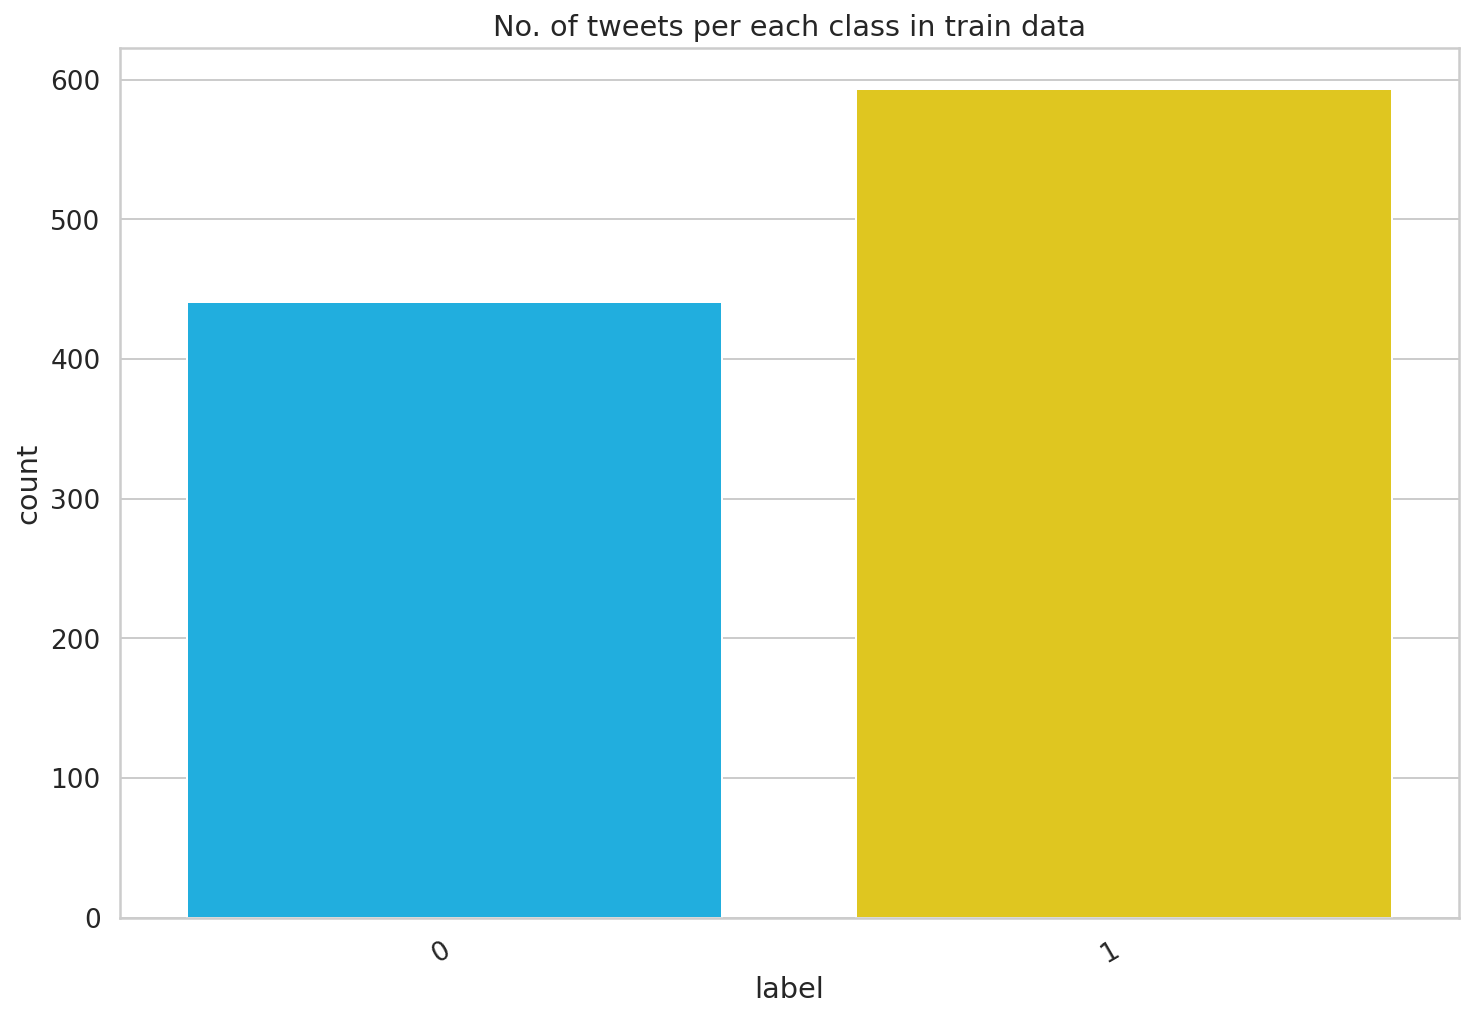

In [ ]:
chart = sns.countplot(train.label, palette=HAPPY_COLORS_PALETTE)
plt.title("No. of tweets per each class in train data")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

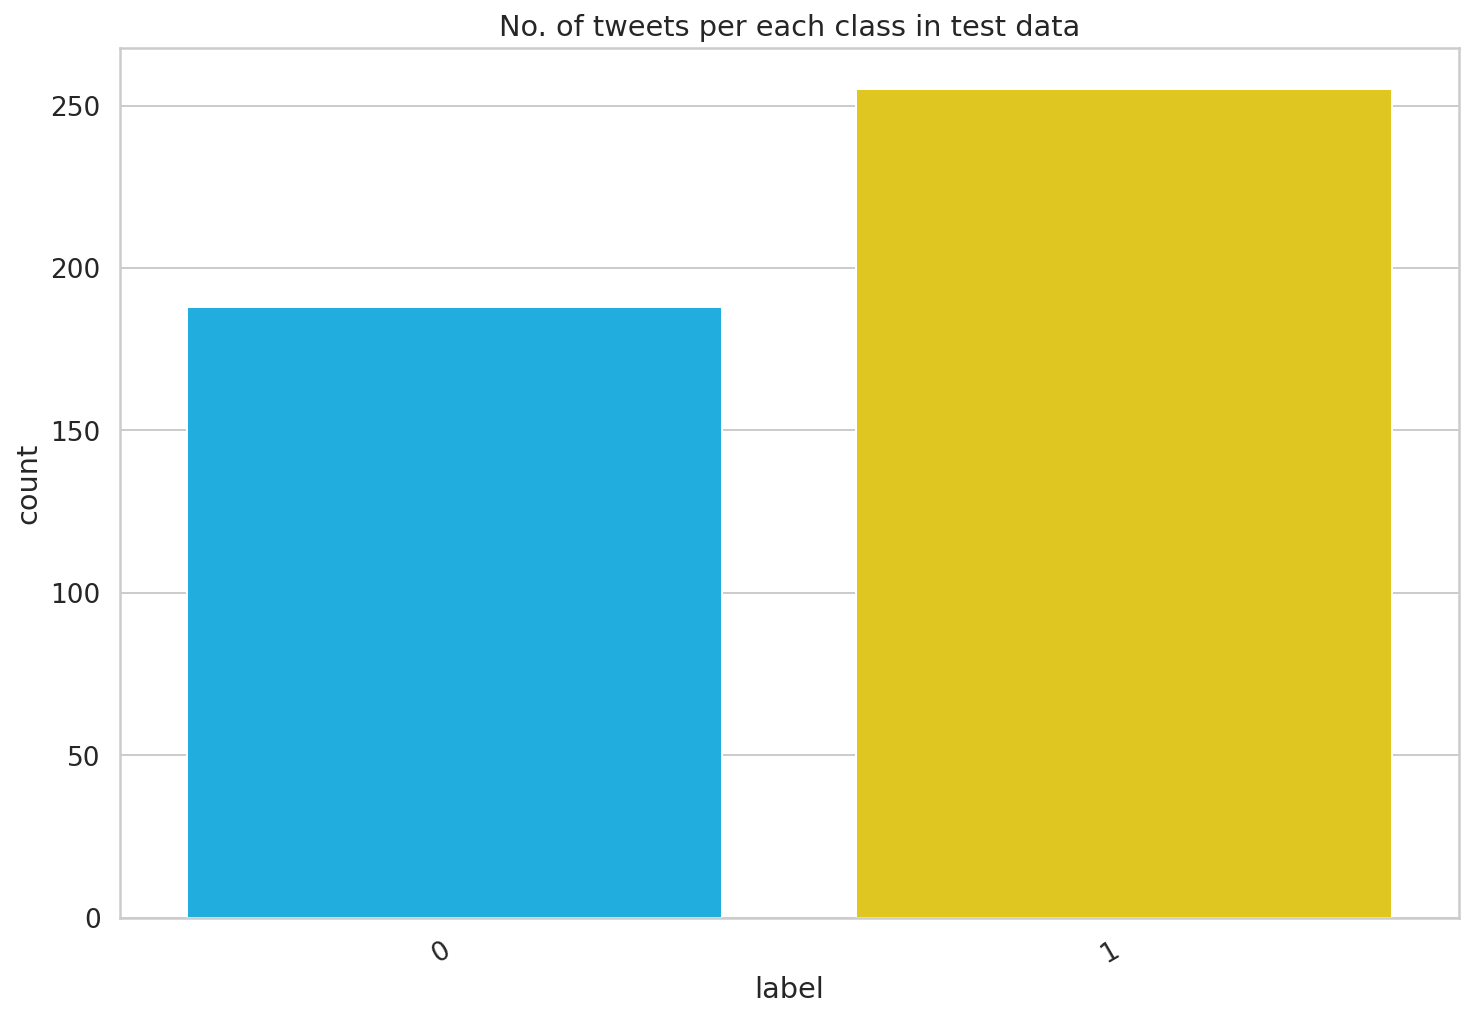

In [ ]:
chart = sns.countplot(test.label, palette=HAPPY_COLORS_PALETTE)
plt.title("No. of tweets per each class in test data")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

**THE BERT START PROPERLY HERE**

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2021-06-25 15:31:35--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.176, 142.250.81.208, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M  88.9MB/s    in 4.4s    

2021-06-25 15:31:39 (88.9 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]



In [ ]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
os.makedirs("model2", exist_ok=True)

In [ ]:
!mv uncased_L-12_H-768_A-12/ model2

mv: cannot stat 'uncased_L-12_H-768_A-12/': No such file or directory


In [ ]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

#**Preprocessing**

In [ ]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [ ]:
tokenizer.tokenize("I can't wait to visit Kingsley again!")

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'kingsley', 'again', '!']

In [ ]:
tokens = tokenizer.tokenize("I can't wait to visit Kingsley again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 22819, 2153, 999]

In [ ]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=512, activation="relu")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=256, activation="relu")(logits)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=256, activation="relu")(logits)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=128, activation="relu")(logits)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

#**Training**

In [ ]:
classes = train.label.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

1034it [00:00, 2735.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
443it [00:00, 2567.32it/s]

max seq_len 39


In [ ]:
data.max_seq_len

39

In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 39, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fa3b8ab4750> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 39)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 39, 768)           108890112 
_________________________________________________________________
lambda_3 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               393728    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               1313

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
log_dir = "log/cyberbulling/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_data= ([data.test_x], [data.test_y]),
  batch_size=128,
  shuffle=True,
  epochs=50,
  callbacks=[tensorboard_callback]
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


9/9 [==============================] - 32s 2s/step - loss: 0.9179 - acc: 0.5106 - val_loss: 0.6816 - val_acc: 0.5756
Epoch 2/50
9/9 [==============================] - 11s 1s/step - loss: 0.8031 - acc: 0.5193 - val_loss: 0.6808 - val_acc: 0.5756
Epoch 3/50
9/9 [==============================] - 11s 1s/step - loss: 0.8019 - acc: 0.4865 - val_loss: 0.6803 - val_acc: 0.5756
Epoch 4/50
9/9 [==============================] - 13s 1s/step - loss: 0.7973 - acc: 0.5280 - val_loss: 0.6826 - val_acc: 0.5756
Epoch 5/50
9/9 [==============================] - 12s 1s/step - loss: 0.7713 - acc: 0.5464 - val_loss: 0.6854 - val_acc: 0.5756
Epoch 6/50
9/9 [==============================] - 11s 1s/step - loss: 0.7779 - acc: 0.5019 - val_loss: 0.6889 - val_acc: 0.5869
Epoch 7/50
9/9 [==============================] - 11s 1s/step - loss: 0.7348 - acc: 0.5309 - val_loss: 0.6889 - val_acc: 0.5824
Epoch 8/50
9/9 [==============================] - 11s 1s/step - loss: 0.7472 - acc: 0.5193 - val_loss: 0.6883 - val

#**Evaluation**

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir log

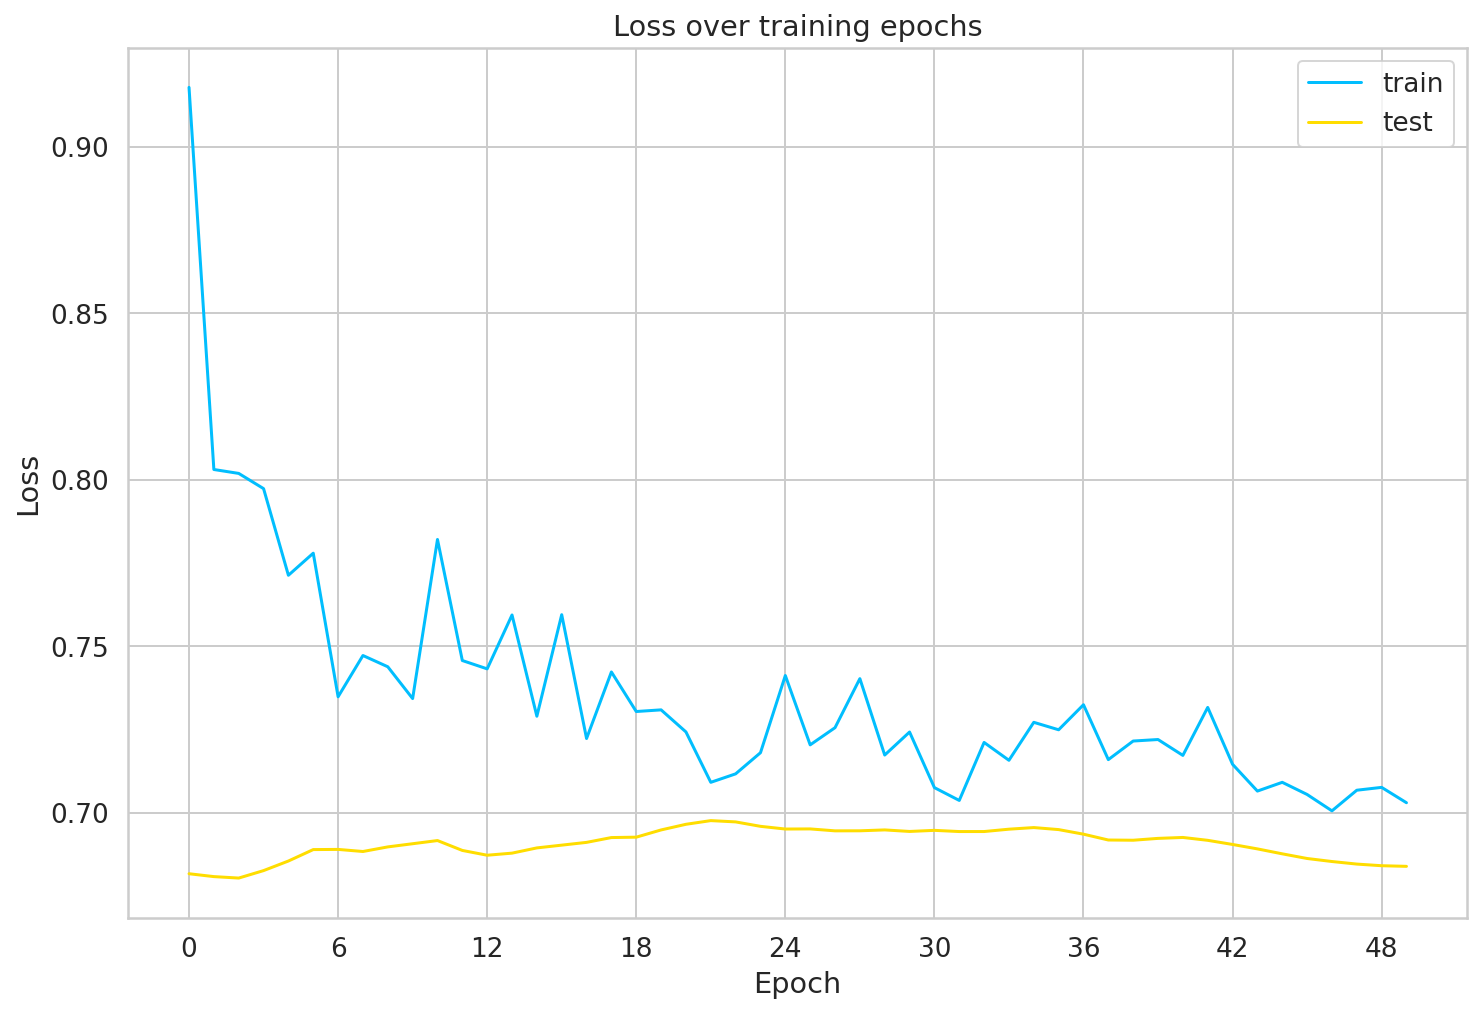

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

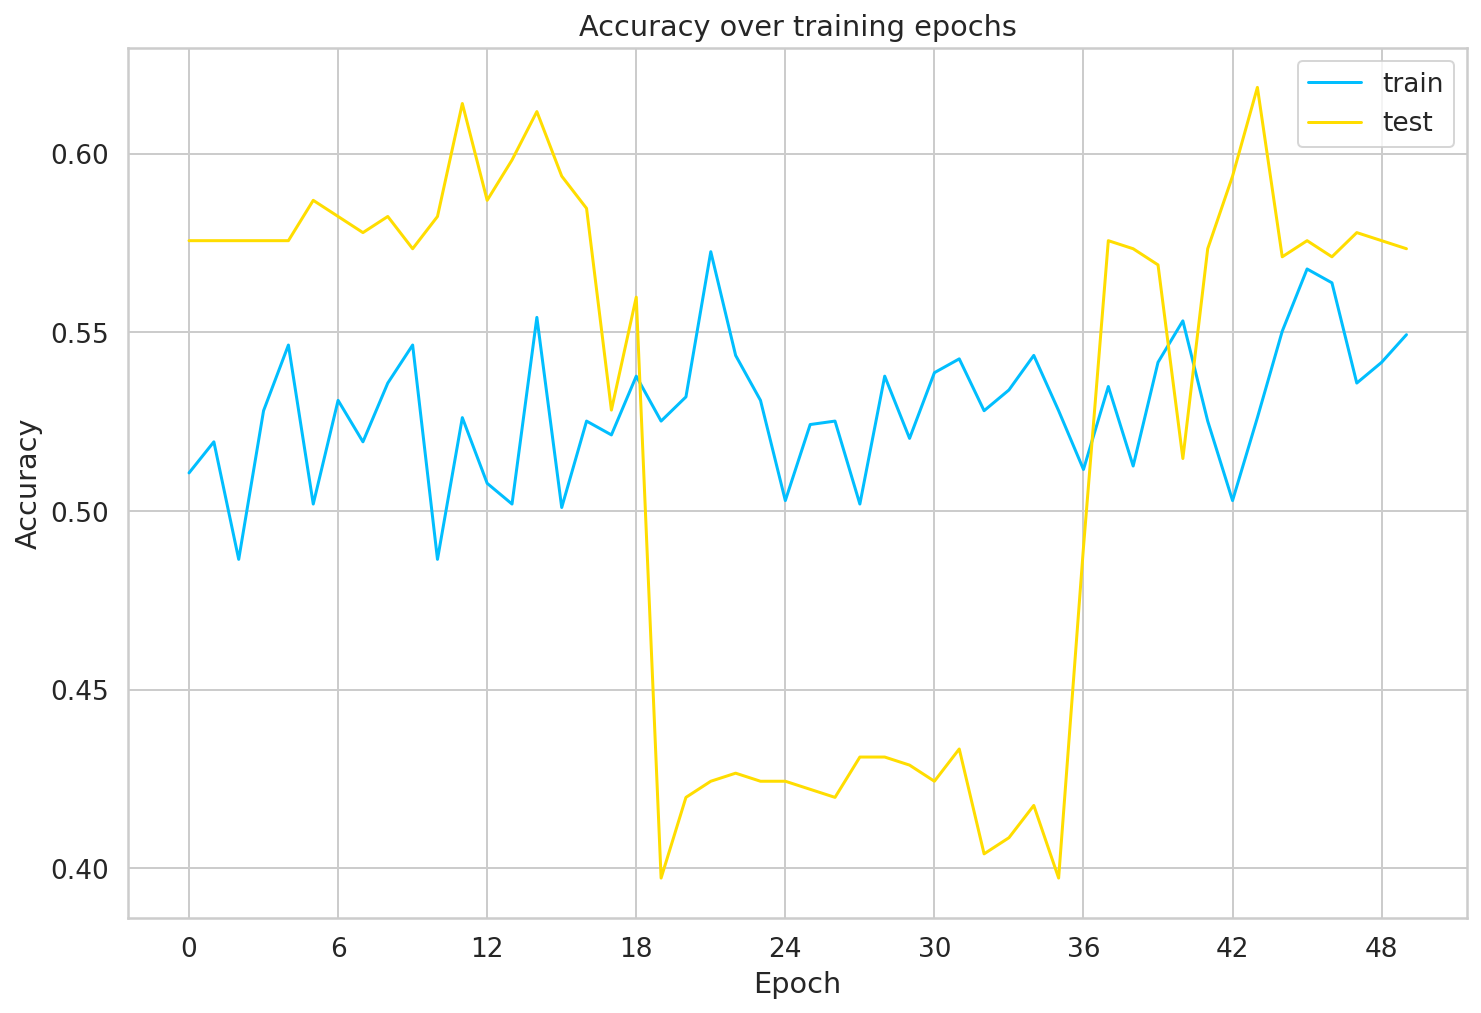

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


14/14 [==============================] - 1s 96ms/step - loss: 0.6839 - acc: 0.5734
train acc 0.5744680762290955
test acc 0.5733634233474731


In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [ ]:
print(classification_report(data.test_y, y_pred, target_names=classes))

TypeError: ignored

In [ ]:
import sklearn.metrics as sm
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
print(cm) 
print(df_cm)

print("recall:", round(sm.recall_score(data.test_y, y_pred), 4))
print("precision:", round(sm.precision_score(data.test_y, y_pred), 4))
print("f1 score:", round(sm.f1_score(data.test_y, y_pred), 4))

# Normalize CM
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#print(norm_cm)

df_norm_cm = pd.DataFrame(norm_cm, index=classes, columns=classes)
#print(df_norm_cm)

[[  1 187]
 [  2 253]]
   0    1
0  1  187
1  2  253
recall: 0.9922
precision: 0.575
f1 score: 0.7281


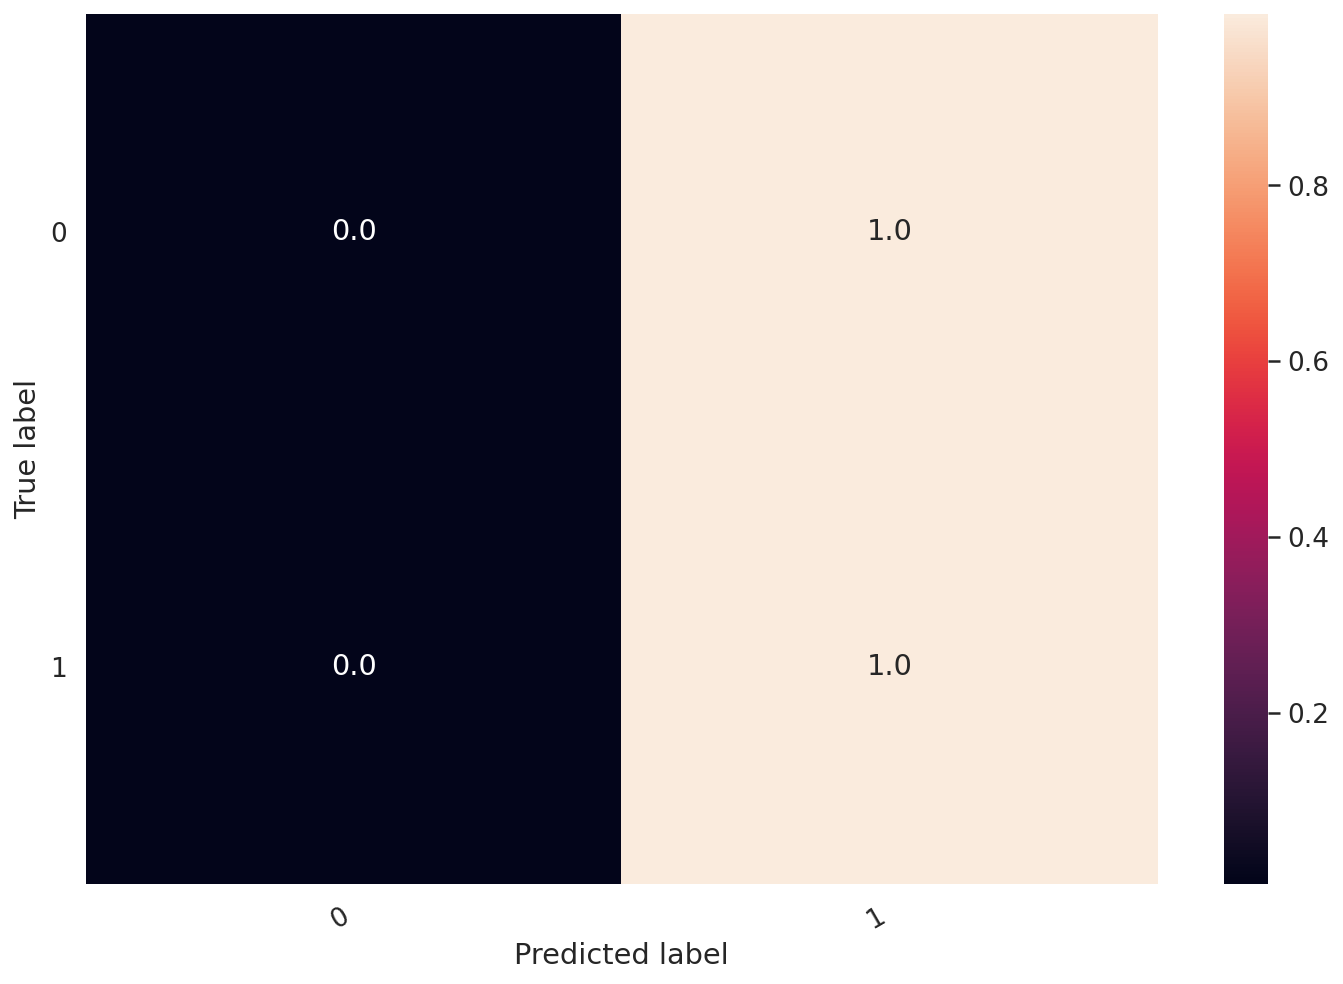

In [ ]:
hmap = sns.heatmap(df_norm_cm, annot=True, fmt="0.1f")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
sentences = [
  "What's your age?",
  "fuck"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: What's your age? 
intent: 1

text: fuck 
intent: 1

